In [ ]:
!unzip image_and_mask.zip

Streaming output truncated to the last 5000 lines.
  inflating: image_and_mask/Mask/000000047940.png  
  inflating: image_and_mask/Mask/000000232383.png  
  inflating: image_and_mask/Mask/000000457754.png  
  inflating: image_and_mask/Mask/000000056865.png  
  inflating: image_and_mask/Mask/000000268927.png  
  inflating: image_and_mask/Mask/000000414679.png  
  inflating: image_and_mask/Mask/000000028377.png  
  inflating: image_and_mask/Mask/000000127050.png  
  inflating: image_and_mask/Mask/000000503311.png  
  inflating: image_and_mask/Mask/000000161011.png  
  inflating: image_and_mask/Mask/000000170849.png  
  inflating: image_and_mask/Mask/000000520251.png  
  inflating: image_and_mask/Mask/000000239229.png  
  inflating: image_and_mask/Mask/000000144534.png  
  inflating: image_and_mask/Mask/000000560675.png  
  inflating: image_and_mask/Mask/000000009420.png  
  inflating: image_and_mask/Mask/000000139291.png  
  inflating: image_and_mask/Mask/000000407822.png  
  inflating: 

In [1]:
# DeepLabV3 ResNet50 Semantic Segmentation - COMPLETE WORKING VERSION

import os, math, time, random, gc
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"  # reduce fragmentation

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image
from torchvision.transforms import functional as TF
from torchvision import transforms
from torchvision.models.segmentation import (
    deeplabv3_resnet50,
    DeepLabV3_ResNet50_Weights,
)
from torchvision.models import ResNet50_Weights
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image


In [7]:
# ---------------------------
# CONFIGURATION
# ---------------------------
DATA_DIR_IMAGES = "/Users/spoorthivattem/Desktop/Roads/Images"  # folder of images
DATA_DIR_MASKS = "/Users/spoorthivattem/Desktop/Roads/Masks"   # folder of masks
IMG_EXTS = {".jpg", ".jpeg", ".png"}  # allowed image extensions
MASK_EXTS = {".png", ".jpg"}  # allowed mask extensions

IMAGE_SIZE = 256  # keep 256 on T4 for ResNet50
BATCH_SIZE = 2    # 1 or 2 on T4; increase only if you have spare VRAM
EPOCHS = 20
LEARNING_RATE = 3e-4
VAL_SPLIT = 0.15
NUM_WORKERS = 0   # Set to 0 to avoid multiprocessing issues
SEED = 42
CHECKPOINT_PATH = "/content/deeplabv3_r50_bin.ckpt"

In [8]:
# ---------------------------
# SETUP
# ---------------------------
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark = True
torch.backends.cudnn.deterministic = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if device.type == "cuda":
    free, total = torch.cuda.mem_get_info()
    print(f"CUDA: {torch.cuda.get_device_name(0)} | Free: {free/1e9:.2f} GB / {total/1e9:.2f} GB")

In [17]:
import os

def list_pairs(img_dir, mask_dir):
    imgs = []

    for img_file in sorted(os.listdir(img_dir)):
        if not img_file.endswith(".png"):
            continue

        # Remove extension
        base = os.path.splitext(img_file)[0]

        # Find matching mask using startswith
        matching_masks = [
            m for m in os.listdir(mask_dir)
            if m.startswith(base) and m.endswith("_label_ground-truth_coco-panoptic.png")
        ]

        if matching_masks:
            mask_file = matching_masks[0]
            imgs.append((os.path.join(img_dir, img_file),
                         os.path.join(mask_dir, mask_file)))

    if not imgs:
        raise RuntimeError(
            f"No (image, mask) pairs found.\nCheck:\n  Images: {img_dir}\n  Masks: {mask_dir}"
        )
    return imgs


In [18]:
# ---------------------------
# DATASET CLASS (COMPLETELY FIXED)
# ---------------------------
class SegDataset(Dataset):
    def __init__(self, pairs, image_size=256, train=True):
        self.pairs = pairs
        self.image_size = image_size
        self.train = train

        # FIXED: Added ToTensor() before ConvertImageDtype
        self.img_transform = transforms.Compose([
            transforms.Resize((image_size, image_size),
                            interpolation=transforms.InterpolationMode.BILINEAR,
                            antialias=True),
            transforms.ToTensor(),  # CRITICAL: Convert PIL to tensor FIRST
            transforms.ConvertImageDtype(torch.float32),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                               std=[0.229, 0.224, 0.225]),
        ])

        # FIXED: Added ToTensor() for masks too
        self.mask_transform = transforms.Compose([
            transforms.Resize((image_size, image_size),
                            interpolation=transforms.InterpolationMode.NEAREST),
            transforms.ToTensor(),  # CRITICAL: Convert PIL to tensor FIRST
        ])

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        img_path, mask_path = self.pairs[idx]

        # Load as PIL Images
        img = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")

        # Optional simple augments for train
        if self.train:
            if random.random() < 0.5:
                img = TF.hflip(img)
                mask = TF.hflip(mask)
            if random.random() < 0.2:
                img = TF.adjust_brightness(img, 0.9 + 0.2*random.random())

        # Apply transforms (now properly converts PIL -> tensor)
        img = self.img_transform(img)
        mask = self.mask_transform(mask)

        # Convert mask to binary {0,1}
        mask = (mask > 0.5).float()

        return img, mask

In [19]:
print(DATA_DIR_IMAGES)
print(DATA_DIR_MASKS)


/Users/spoorthivattem/Desktop/Roads/Images
/Users/spoorthivattem/Desktop/Roads/Masks


In [20]:
# ---------------------------
# DATA LOADERS (FIXED)
# ---------------------------
all_pairs = list_pairs(DATA_DIR_IMAGES, DATA_DIR_MASKS)
random.shuffle(all_pairs)
n_val = max(1, int(len(all_pairs) * VAL_SPLIT))
val_pairs = all_pairs[:n_val]
train_pairs = all_pairs[n_val:]

train_ds = SegDataset(train_pairs, image_size=IMAGE_SIZE, train=True)
val_ds = SegDataset(val_pairs, image_size=IMAGE_SIZE, train=False)

# FIXED: Added drop_last=True to prevent BatchNorm errors
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,
                         num_workers=NUM_WORKERS, pin_memory=True,
                         persistent_workers=(NUM_WORKERS>0),
                         drop_last=True)  # CRITICAL: Prevents batch size = 1 errors

val_loader = DataLoader(val_ds, batch_size=1, shuffle=False,
                       num_workers=NUM_WORKERS, pin_memory=True,
                       persistent_workers=(NUM_WORKERS>0))

print(f"Train: {len(train_ds)} | Val: {len(val_ds)} | Image size: {IMAGE_SIZE} | Batch size: {BATCH_SIZE}")

Train: 83 | Val: 14 | Image size: 256 | Batch size: 2


In [21]:
# ---------------------------
# MODEL SETUP
# ---------------------------
# Use ResNet50 backbone weights
weights_backbone = ResNet50_Weights.IMAGENET1K_V1
model = deeplabv3_resnet50(weights=None, weights_backbone=weights_backbone, num_classes=1)
model = model.to(device)

# Loss + Optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE)

# Mixed precision scaler (FIXED: Updated to new API)
scaler = torch.amp.GradScaler('cuda', enabled=(device.type == "cuda"))

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /Users/spoorthivattem/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████████████████████████████████| 97.8M/97.8M [00:43<00:00, 2.34MB/s]


In [22]:
# ---------------------------
# METRICS
# ---------------------------
@torch.no_grad()
def compute_iou(pred, target, eps=1e-7):
    # pred, target: (N,1,H,W) in {0,1}
    inter = (pred * target).sum(dim=(1,2,3))
    union = (pred + target - pred*target).sum(dim=(1,2,3)) + eps
    return (inter / union).mean().item()

@torch.no_grad()
def compute_dice(pred, target, eps=1e-7):
    inter = (pred * target).sum(dim=(1,2,3))
    denom = (pred + target).sum(dim=(1,2,3)) + eps
    return (2*inter / denom).mean().item()

In [23]:
# ---------------------------
# TRAIN / EVAL LOOPS (FIXED)
# ---------------------------
def train_one_epoch(epoch):
    model.train()
    torch.cuda.empty_cache()
    running = 0.0
    t0 = time.time()

    for imgs, masks in train_loader:
        imgs = imgs.to(device, non_blocking=True)
        masks = masks.to(device, non_blocking=True)

        # SAFETY CHECK: Skip if somehow batch size is still 1
        if imgs.size(0) == 1:
            print(f"Skipping batch with size 1 in epoch {epoch}")
            continue

        optimizer.zero_grad(set_to_none=True)
        # FIXED: Updated autocast API
        with torch.amp.autocast('cuda', enabled=(device.type == "cuda")):
            out = model(imgs)["out"]  # (N,1,H,W) logits
            loss = criterion(out, masks)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running += loss.item() * imgs.size(0)

    return running / len(train_loader.dataset), time.time()-t0

@torch.no_grad()
def evaluate():
    model.eval()
    loss_sum = 0.0
    iou_sum = 0.0
    dice_sum = 0.0
    count = 0

    for imgs, masks in val_loader:
        imgs = imgs.to(device, non_blocking=True)
        masks = masks.to(device, non_blocking=True)

        # FIXED: Updated autocast API
        with torch.amp.autocast('cuda', enabled=(device.type == "cuda")):
            out = model(imgs)["out"]
            loss = criterion(out, masks)

        probs = torch.sigmoid(out)
        preds = (probs > 0.5).float()

        loss_sum += loss.item()
        iou_sum += compute_iou(preds, masks)
        dice_sum += compute_dice(preds, masks)
        count += 1

    return loss_sum / max(1,count), iou_sum / max(1,count), dice_sum / max(1,count)

In [24]:
# ---------------------------
# CHECKPOINT UTILITIES
# ---------------------------
def save_ckpt(path):
    torch.save({"model": model.state_dict(),
                "opt": optimizer.state_dict(),
                "scaler": scaler.state_dict()}, path)
    print(f"Checkpoint saved to {path}")

def load_ckpt(path):
    ckpt = torch.load(path, map_location=device)
    model.load_state_dict(ckpt["model"])
    optimizer.load_state_dict(ckpt["opt"])
    scaler.load_state_dict(ckpt["scaler"])
    print(f"Checkpoint loaded from {path}")


In [ ]:
# ---------------------------
# TRAINING LOOP (COMPLETE & ROBUST)
# ---------------------------
print("Starting training...")
print(f"Total training samples: {len(train_ds)}")
print(f"Total validation samples: {len(val_ds)}")
print(f"Batches per epoch: {len(train_loader)}")

train_losses = []
val_losses = []
val_ious = []
val_dices = []
best_val = math.inf

for epoch in range(1, EPOCHS+1):
    try:
        # Train for one epoch
        tr_loss, tr_time = train_one_epoch(epoch)
        train_losses.append(tr_loss)

        # Evaluate
        val_loss, val_iou, val_dice = evaluate()
        val_losses.append(val_loss)
        val_ious.append(val_iou)
        val_dices.append(val_dice)

        print(f"[{epoch:03d}/{EPOCHS}] "
              f"train_loss={tr_loss:.4f} ({tr_time:.1f}s) | "
              f"val_loss={val_loss:.4f} IoU={val_iou:.4f} Dice={val_dice:.4f}")

        # Save best checkpoint
        if val_loss < best_val:
            best_val = val_loss
            save_ckpt(CHECKPOINT_PATH)
            print(f"🎉 New best model! Val Loss: {val_loss:.4f}")

        # Memory cleanup every few epochs
        if epoch % 5 == 0:
            torch.cuda.empty_cache()
            gc.collect()

    except Exception as e:
        print(f"❌ Error in epoch {epoch}: {e}")
        import traceback
        traceback.print_exc()

        # Try to continue training
        torch.cuda.empty_cache()
        gc.collect()
        continue

# Load best model
if os.path.isfile(CHECKPOINT_PATH):
    load_ckpt(CHECKPOINT_PATH)
    model.eval()
    print(f"✅ Loaded best checkpoint")
else:
    print("⚠️ No checkpoint found, using current model state")

Starting training...
Total training samples: 83
Total validation samples: 14
Batches per epoch: 41
[001/20] train_loss=0.3352 (48.1s) | val_loss=0.1408 IoU=0.0000 Dice=0.0000
❌ Error in epoch 1: Parent directory /content does not exist.


Traceback (most recent call last):
  File "/var/folders/l1/kgd0gw3x2pqg433l5ds6tqnh0000gp/T/ipykernel_3661/1631620995.py", line 34, in <module>
    save_ckpt(CHECKPOINT_PATH)
  File "/var/folders/l1/kgd0gw3x2pqg433l5ds6tqnh0000gp/T/ipykernel_3661/1353628130.py", line 5, in save_ckpt
    torch.save({"model": model.state_dict(),
  File "/opt/anaconda3/lib/python3.12/site-packages/torch/serialization.py", line 849, in save
    with _open_zipfile_writer(f) as opened_zipfile:
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/torch/serialization.py", line 716, in _open_zipfile_writer
    return container(name_or_buffer)
           ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/torch/serialization.py", line 687, in __init__
    super().__init__(torch._C.PyTorchFileWriter(self.name))
                     ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
RuntimeError: Parent directory /content does not exist.


[002/20] train_loss=0.0791 (50.9s) | val_loss=0.0597 IoU=0.0000 Dice=0.0000
❌ Error in epoch 2: Parent directory /content does not exist.


Traceback (most recent call last):
  File "/var/folders/l1/kgd0gw3x2pqg433l5ds6tqnh0000gp/T/ipykernel_3661/1631620995.py", line 34, in <module>
    save_ckpt(CHECKPOINT_PATH)
  File "/var/folders/l1/kgd0gw3x2pqg433l5ds6tqnh0000gp/T/ipykernel_3661/1353628130.py", line 5, in save_ckpt
    torch.save({"model": model.state_dict(),
  File "/opt/anaconda3/lib/python3.12/site-packages/torch/serialization.py", line 849, in save
    with _open_zipfile_writer(f) as opened_zipfile:
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/torch/serialization.py", line 716, in _open_zipfile_writer
    return container(name_or_buffer)
           ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/torch/serialization.py", line 687, in __init__
    super().__init__(torch._C.PyTorchFileWriter(self.name))
                     ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
RuntimeError: Parent directory /content does not exist.


[003/20] train_loss=0.0476 (49.9s) | val_loss=0.0408 IoU=0.0000 Dice=0.0000
❌ Error in epoch 3: Parent directory /content does not exist.


Traceback (most recent call last):
  File "/var/folders/l1/kgd0gw3x2pqg433l5ds6tqnh0000gp/T/ipykernel_3661/1631620995.py", line 34, in <module>
    save_ckpt(CHECKPOINT_PATH)
  File "/var/folders/l1/kgd0gw3x2pqg433l5ds6tqnh0000gp/T/ipykernel_3661/1353628130.py", line 5, in save_ckpt
    torch.save({"model": model.state_dict(),
  File "/opt/anaconda3/lib/python3.12/site-packages/torch/serialization.py", line 849, in save
    with _open_zipfile_writer(f) as opened_zipfile:
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/torch/serialization.py", line 716, in _open_zipfile_writer
    return container(name_or_buffer)
           ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/torch/serialization.py", line 687, in __init__
    super().__init__(torch._C.PyTorchFileWriter(self.name))
                     ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
RuntimeError: Parent directory /content does not exist.


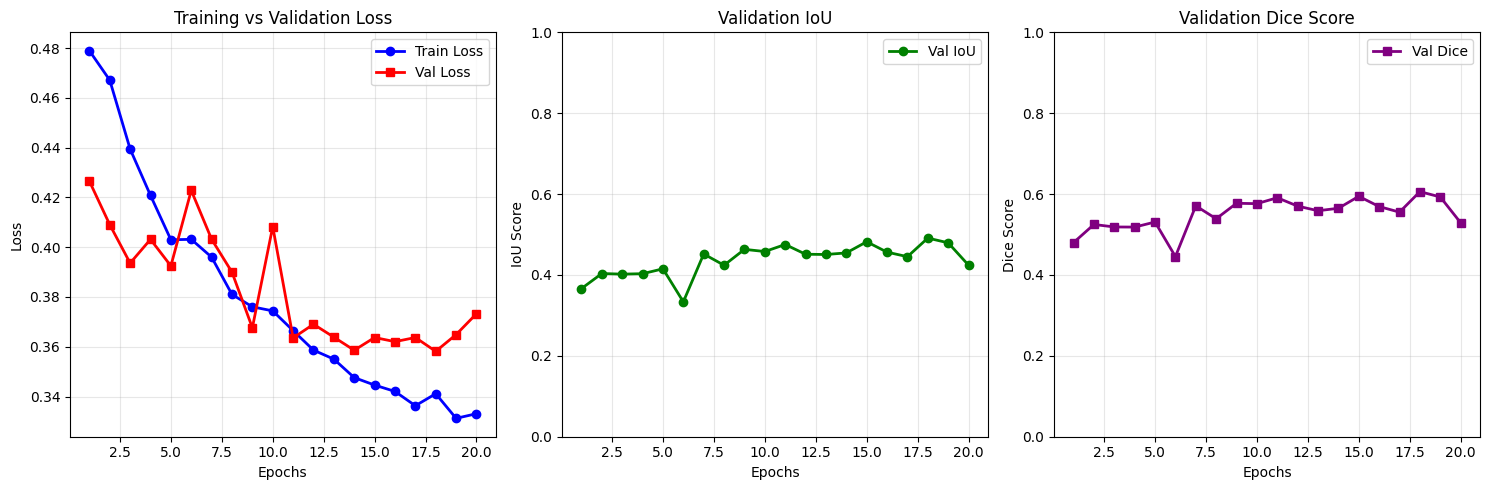


📊 FINAL RESULTS:
Best validation loss: 0.3582
Final validation IoU: 0.4242
Final validation Dice: 0.5291
Max validation IoU: 0.4912
Max validation Dice: 0.6061


In [ ]:
# ---------------------------
# RESULTS VISUALIZATION
# ---------------------------
if len(train_losses) > 0:
    plt.figure(figsize=(15, 5))

    # Plot 1: Losses
    plt.subplot(1, 3, 1)
    epochs_range = range(1, len(train_losses)+1)
    plt.plot(epochs_range, train_losses, 'b-o', label='Train Loss', linewidth=2)
    plt.plot(epochs_range, val_losses, 'r-s', label='Val Loss', linewidth=2)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training vs Validation Loss")
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Plot 2: IoU
    plt.subplot(1, 3, 2)
    plt.plot(epochs_range, val_ious, 'g-o', label='Val IoU', linewidth=2)
    plt.xlabel("Epochs")
    plt.ylabel("IoU Score")
    plt.title("Validation IoU")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.ylim([0, 1])

    # Plot 3: Dice
    plt.subplot(1, 3, 3)
    plt.plot(epochs_range, val_dices, 'purple', marker='s', label='Val Dice', linewidth=2)
    plt.xlabel("Epochs")
    plt.ylabel("Dice Score")
    plt.title("Validation Dice Score")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.ylim([0, 1])

    plt.tight_layout()
    plt.show()

    # Print final statistics
    print(f"\n📊 FINAL RESULTS:")
    print(f"Best validation loss: {best_val:.4f}")
    print(f"Final validation IoU: {val_ious[-1]:.4f}")
    print(f"Final validation Dice: {val_dices[-1]:.4f}")
    print(f"Max validation IoU: {max(val_ious):.4f}")
    print(f"Max validation Dice: {max(val_dices):.4f}")



🖼️ Visualizing 3 sample predictions...


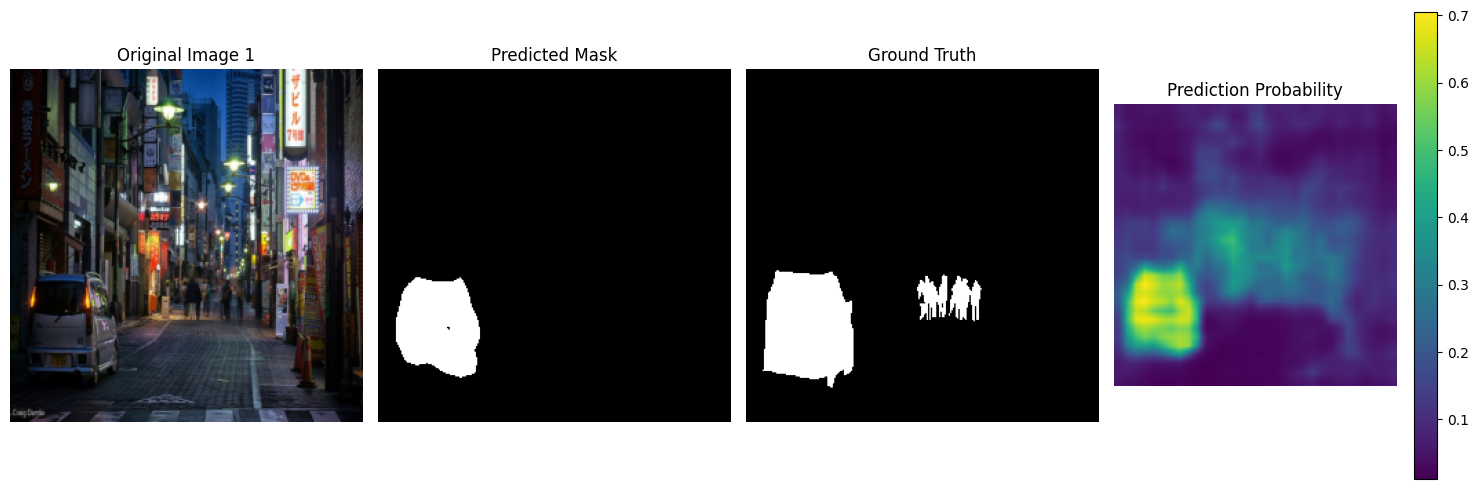

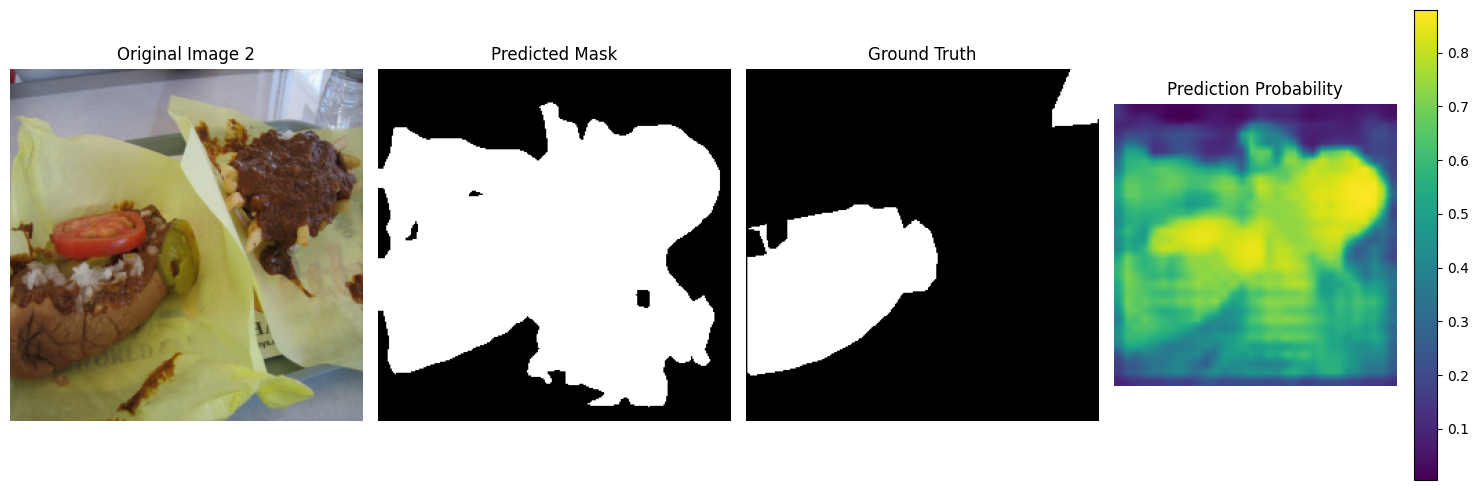

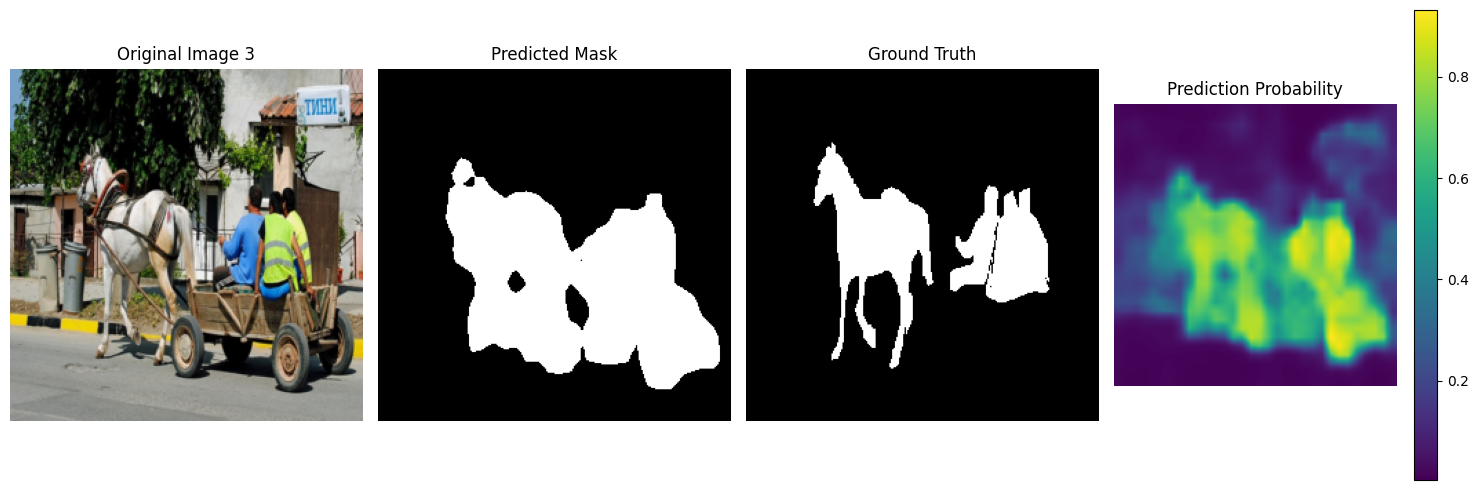


🎉 Training completed successfully!
Model saved at: /content/deeplabv3_r50_bin.ckpt
You can now use the trained model for inference!


In [ ]:
# ---------------------------
# SAMPLE PREDICTIONS VISUALIZATION (FIXED)
# ---------------------------
def visualize_samples(num_samples=3):
    """Visualize sample predictions"""
    model.eval()
    samples = random.sample(val_pairs if len(val_pairs)>=num_samples else train_pairs,
                           k=min(num_samples, len(all_pairs)))

    print(f"\n🖼️ Visualizing {len(samples)} sample predictions...")

    for i, (img_path, mask_path) in enumerate(samples):
        # Load raw images
        raw_img = Image.open(img_path).convert("RGB")
        raw_mask = Image.open(mask_path).convert("L")

        # FIXED: Proper transform pipeline matching dataset
        img_tensor = transforms.Compose([
            transforms.Resize((IMAGE_SIZE, IMAGE_SIZE),
                            interpolation=transforms.InterpolationMode.BILINEAR,
                            antialias=True),
            transforms.ToTensor(),  # CRITICAL: Convert to tensor first
            transforms.ConvertImageDtype(torch.float32),
            transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
        ])(raw_img).unsqueeze(0).to(device)

        # Predict
        with torch.no_grad():  # ✅ ADDED: Disable gradients for inference
            with torch.amp.autocast('cuda', enabled=(device.type == "cuda")):
                logits = model(img_tensor)["out"]

        # ✅ FIXED: Added .detach() before .cpu().numpy()
        prob = torch.sigmoid(logits)[0,0].detach().cpu().numpy()  # H,W
        pred_mask_01 = (prob > 0.5).astype(np.uint8)*255

        # Resize for display
        disp_img = raw_img.resize((IMAGE_SIZE, IMAGE_SIZE), Image.BILINEAR)
        disp_gt = raw_mask.resize((IMAGE_SIZE, IMAGE_SIZE), Image.NEAREST)
        disp_pred = Image.fromarray(pred_mask_01).resize((IMAGE_SIZE, IMAGE_SIZE), Image.NEAREST)

        # Plot
        plt.figure(figsize=(15, 5))



        plt.subplot(1, 4, 1)
        plt.imshow(disp_img)
        plt.title(f"Original Image {i+1}")
        plt.axis("off")

        plt.subplot(1, 4, 2)
        plt.imshow(disp_pred, cmap="gray")
        plt.title("Predicted Mask")
        plt.axis("off")

        plt.subplot(1, 4, 3)
        plt.imshow(disp_gt, cmap="gray")
        plt.title("Ground Truth")
        plt.axis("off")

        plt.subplot(1, 4, 4)
        plt.imshow(prob, cmap="viridis")
        plt.title("Prediction Probability")
        plt.colorbar()
        plt.axis("off")



        plt.tight_layout()
        plt.show()

# Show sample predictions
visualize_samples(num_samples=3)

print(f"\n🎉 Training completed successfully!")
print(f"Model saved at: {CHECKPOINT_PATH}")
print(f"You can now use the trained model for inference!")



🖼️ Visualizing 20 sample predictions...


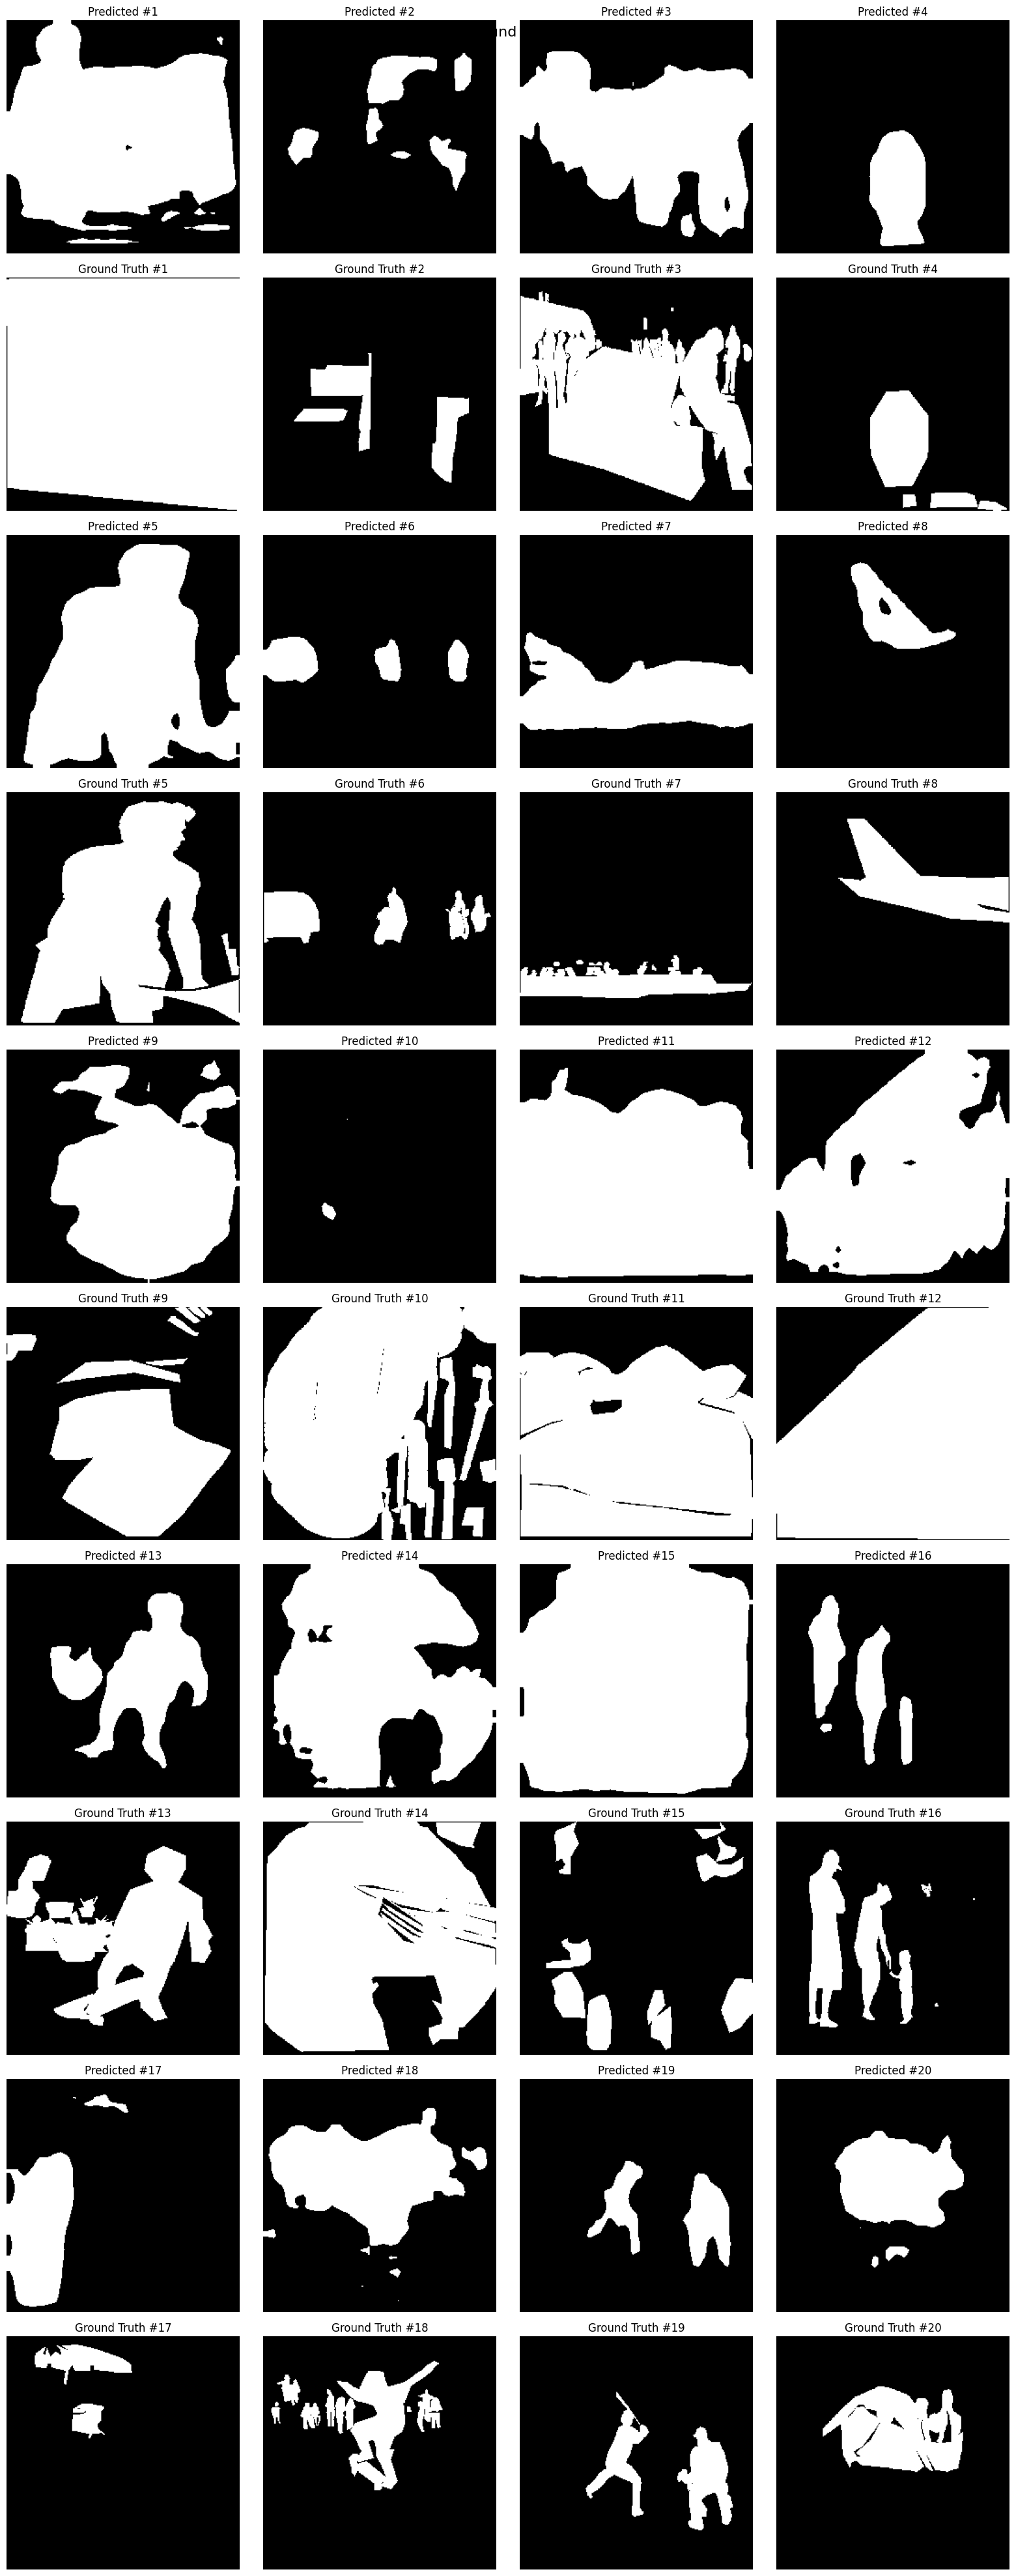

In [ ]:
# ---------------------------
# CORRECT APPROACH - VISUALIZE 20 SAMPLES
# ---------------------------
def visualize_samples(num_samples=20):
    """Visualize sample predictions"""
    model.eval()
    samples = random.sample(val_pairs if len(val_pairs)>=num_samples else train_pairs,
                           k=min(num_samples, len(all_pairs)))

    print(f"\n🖼️ Visualizing {len(samples)} sample predictions...")

    # Create grid layout for 20 samples (4 columns, 5 rows for predictions + ground truth)
    fig, axes = plt.subplots(10, 4, figsize=(16, 40))  # 10 rows (5 for pred, 5 for GT), 4 columns

    for i, (img_path, mask_path) in enumerate(samples):
        # Load raw images
        raw_img = Image.open(img_path).convert("RGB")
        raw_mask = Image.open(mask_path).convert("L")

        # Transform pipeline
        img_tensor = transforms.Compose([
            transforms.Resize((IMAGE_SIZE, IMAGE_SIZE),
                            interpolation=transforms.InterpolationMode.BILINEAR,
                            antialias=True),
            transforms.ToTensor(),
            transforms.ConvertImageDtype(torch.float32),
            transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
        ])(raw_img).unsqueeze(0).to(device)

        # Predict
        with torch.no_grad():
            with torch.amp.autocast('cuda', enabled=(device.type == "cuda")):
                logits = model(img_tensor)["out"]

        prob = torch.sigmoid(logits)[0,0].detach().cpu().numpy()
        pred_mask_01 = (prob > 0.5).astype(np.uint8)*255

        # Resize for display
        disp_gt = raw_mask.resize((IMAGE_SIZE, IMAGE_SIZE), Image.NEAREST)
        disp_pred = Image.fromarray(pred_mask_01).resize((IMAGE_SIZE, IMAGE_SIZE), Image.NEAREST)

        # Calculate positions in grid
        row = i // 4  # Which set of 4 samples
        col = i % 4   # Which column in the set

        # Top half: Predicted masks
        axes[row * 2, col].imshow(disp_pred, cmap="gray")
        axes[row * 2, col].set_title(f"Predicted #{i+1}")
        axes[row * 2, col].axis("off")

        # Bottom half: Ground truth masks
        axes[row * 2 + 1, col].imshow(disp_gt, cmap="gray")
        axes[row * 2 + 1, col].set_title(f"Ground Truth #{i+1}")
        axes[row * 2 + 1, col].axis("off")

    plt.suptitle("Predictions vs Ground Truth - 20 Samples", fontsize=16)
    plt.tight_layout()
    plt.show()

# Show 20 samples
visualize_samples(num_samples=20)
